# Environment Setup

In [34]:
!pip install missingno

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from IPython.core.interactiveshell import InteractiveShell
from scipy import stats
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA    

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
# display scientific notation as a float
pd.set_option('display.float_format', lambda x: '%.3f' % x)
custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="white", rc=custom_params, palette="Set2")

encodings = {}

In [50]:
from data_cleaning_lib import (
    create_boxplots,
    create_hist_and_boxplots,
    plot_categorical_counts,
    create_category_encodings,
    write_encodings_csv,
    create_na_mask,
)

Explain the plan for cleaning the data by doing the following:
 1. Examine the entire dataset (regardless of your research question).
 2. Detection and Treatment of Duplicates, Missing Values and Outlier (check for outliers for all numeric variables).
 3. Re express Categorical Variables, if possible (this is optional, but suggested)
 4. Perform PCA (with numerical variables only)

## C1: Plan to Find Anomalies
Propose a plan that includes the relevant techniques and specific steps needed to identify anomalies in the data set.

### Understanding the dataset

In [44]:
df.shape
df.info()

NameError: name 'df' is not defined

In [ ]:
display(df.columns)
display(df.describe())
df.head()

In [ ]:
pd.DataFrame(df.isnull().sum().sort_values(ascending=False))

### Detect Duplicates

In [ ]:
df[df.duplicated()]

In [ ]:
df[df.duplicated(subset=['Customer_id', 'Interaction', 'UID'])]

In [ ]:
# determine if 'Unnamed: 0' and 'CaseOrder' columns have the same values
(df['Unnamed: 0'] == df['CaseOrder']).all()

### Detect Missing Values

In [ ]:
# get column names for any columns with missing values
missing_cols = df.columns[df.isnull().any()]

# create a dataframe of columns with missing values
missing_df = df[missing_cols]
pct_missing_df = pd.DataFrame()

# calculate % missing for columns with missing data
pct_missing_df['missing cnt'] = missing_df.isnull().sum()
pct_missing_df['missing %'] = ((pct_missing_df['missing cnt'] / len(df.index)) * 100)

# sort % missing in descending order
pct_missing_df.sort_values(by='missing cnt', ascending=False, axis=0)

#### Missing Matrix

In [ ]:
# visualize the dataframe's nullity
_ = msno.matrix(missing_df, figsize=(35, 10)) 

#### Missing Bar Chart

In [ ]:
# bar chart visualization of the dataframe's nullity
_ = msno.bar(df, figsize=(25,20), color="gray")

#### Missing Heatmap

In [ ]:
# heatmap visualization of nullity correlation within the DataFrame (displaying 250 records).
# -1 indicates if one variable appears then the other variable is very likely to be missing.
# 0 indicates there is no dependence between the occurrence of missing values of two variables.
# 1 indicates that when one variable appears then the other variable is likely to be present.
_ = msno.heatmap(missing_df.loc[:250], figsize=(25,10))

#### Missing Dendrogram

In [ ]:
# shows the hierarchical relationship between objects
_ = msno.dendrogram(missing_df, orientation='bottom', figsize=(25,5))

### Detect Outliers

#### Z-Scores
find columns with addressable outliers

In [ ]:
def get_zscore_cols(df):
    numeric_df = df.select_dtypes(include=['int64', 'float64']).apply(pd.to_numeric)
    z_score_df = np.abs(stats.zscore(numeric_df, nan_policy='omit')) > 3
    
    col_outlier_counts = z_score_df.sum()
    # create a dataframe using columns with at least 1 outlier     
    outlier_counts_df = col_outlier_counts[col_outlier_counts > 0]

    # outlier column names     
    return outlier_counts_df.index

# numerical columns with notable outliers that we're choosing to ignore
ignored_outlier_cols = ['Lat', 'Lng', 'Population', 'Age', 'Income', 'TotalCharge', 'Additional_charges', 'Doc_visits']

# store the relevant zscore columns that are important to address
z_score_cols = list(set(get_zscore_cols(df)) - set(ignored_outlier_cols))
# columns 
z_score_cols

#### store z-score values for addressable columns

In [ ]:
zscore_df = df[z_score_cols].copy()

for col in z_score_cols:
    zscore_df[f"{col}_zscore"] = stats.zscore(df[col], nan_policy='omit')
    # store values where their absolute values exceeds a z-score of > 3
    zscore_df.loc[abs(zscore_df[f"{col}_zscore"]) > 3, [col, f"{col}_zscore"]]
    
# display zscore values    
zscore_df.iloc[:, zscore_df.columns.str.contains("zscore")]

#### Boxplots

In [ ]:
# create_boxplots(df.loc[:, ~df.columns.isin(['Unnamed: 0', 'CaseOrder'])])        

# display boxplots with known and relevant outliers
create_boxplots(df[z_score_cols])

#### Histograms

In [ ]:
create_histograms(df.loc[:, ~df.columns.isin(['Unnamed: 0', 'CaseOrder'])])

In [ ]:
_ = df.hist(layout=(6,5), figsize = (25,15))

### Re-Expression Categories
convert categorical string values to category data type

In [ ]:
# convert "Soft_drink" nan's to 'No'
df.loc[df["Soft_drink"].isna(), "Soft_drink"] = "No"

# convert "Overweight" float64's to Yes/No bools
df["Overweight"] = df["Overweight"].map({np.nan: "No", 0: "No", 1: "Yes"})

# validate a soft drink value exists for each record
assert len(df["Soft_drink"].isna().index) == len(df.index)

# categorical columns and potential categorical columns
ctg_cols = [
    "Allergic_rhinitis",
    "Area",
    "Arthritis",
    "Asthma",
    "BackPain",
    "Complication_risk",
    "Diabetes",
    "Education",
    "Employment",
    "Gender",
    "HighBlood",
    "Hyperlipidemia",
    "Initial_admin",
    "Marital",
    "Overweight",
    "ReAdmis",
    "Reflux_esophagitis",
    "Services",
    "Soft_drink",
    "Stroke",
    "Timezone",
]

for col in ctg_cols:
    # print(df[col].unique())
    print(f"--- CONVERTING COLUMN: '{col}' to category ---")

    # convert column to a category
    df = df.astype({col: "category"})

    # confirm the values successfully converted
    assert df[col].dtype == "category"

    # report categorical counts
    print(df[col].value_counts(), end="\n\n")

### Cleaning text data



In [ ]:
str_cols = df.select_dtypes('object')
df[str_cols.columns] = str_cols.apply(lambda s: s.str.strip())

# validate all state abbreviations are 2 characters 
assert (df['State'].str.len() == 2).all()

# validate zip codes are 3, 4 or 5 digits
assert df['Zip'].astype('str').str.len().between(3,5).all()

# cross field validation: validate 3 digit zip codes are Puerto Rican addresses
assert (df.loc[df['Zip'].astype('str').str.len() == 3, ['State', 'Zip']]["State"] == 'PR').all()

# Customer_id, Interaction, UID, State,  and Zip 

# validate all Customer_id values are 6 or 7 characters 
pd.DataFrame(df["Customer_id"].str.len()).value_counts()
assert df['Customer_id'].str.len().between(6,7).all()

# validate all Interaction values are 36 characters 
pd.DataFrame(df["Interaction"].str.len()).value_counts()
assert (df['Interaction'].str.len() == 36).all()

# validate all Interaction values are 32 characters 
pd.DataFrame(df["UID"].str.len()).value_counts()
assert (df['UID'].str.len() == 32).all()

### Other Data Cleaning

In [ ]:
# Verify these columns are the same, if so drop the "Unnamed: 0" column
# drop "Unnamed: 0" if dupes
assert df["Unnamed: 0"].ne(df["CaseOrder"]).all()

In [ ]:
# cast to int if this fails
assert df['Age'].dtype == 'int'

In [ ]:
# cast to int if this fails
assert df['Children'].dtype == 'int'

## C2: Justification of Approach
Explain the plan for cleaning the data by doing the following:

2.  Justify your approach for assessing the quality of the data, include:

•  characteristics of the data being assessed,

•  the approach used to assess the quality.

## C3: Justification of Tools
Explain the plan for cleaning the data by doing the following:

3.  Justify your selected programming language and any libraries and packages that will support the data-cleaning process.
    - Python
    - Jupyter Notebooks
    - numpy as np
    - numpy
    - pandas
    - matplotlib.pyplot
    - seaborn
    - missingno
    - sklearn
      - accuracy_score, LassoCV, PCA, RandomForestRegressor, RFE, StandardScaler, SVC, train_test_split, VarianceThreshold
    - fuzzywuzzy
        - process
    - fancyimpute
        - KNN, IterativeImputer
    - statsmodels.api 
      

## C4: Provide the Code
Provide the code you will use to identify the anomalies in the data.

# Part III: Data Cleaning
---

## D1: Cleaning Findings

In [45]:
filename = "./src/Medical Data/medical_raw_data.csv"
df = pd.read_csv(filename)
treated_df = df.copy()

### Duplicate Treatment

In [46]:
treated_df = treated_df.drop_duplicates(subset=['Customer_id', 'Interaction', 'UID'])
assert treated_df.duplicated(subset=['Customer_id', 'Interaction', 'UID']).sum() == 0

### Missing Value Treatment

In [47]:
null_df = treated_df.isnull().sum()
null_counts_df = null_df[null_df > 0].sort_values(ascending=False)

# store the list of column names with missing values
missing_cols = null_counts_df.index

null_counts_df

Children        2588
Soft_drink      2467
Income          2464
Age             2414
Initial_days    1056
Anxiety          984
Overweight       982
dtype: int64

#### Children Imputation Comps

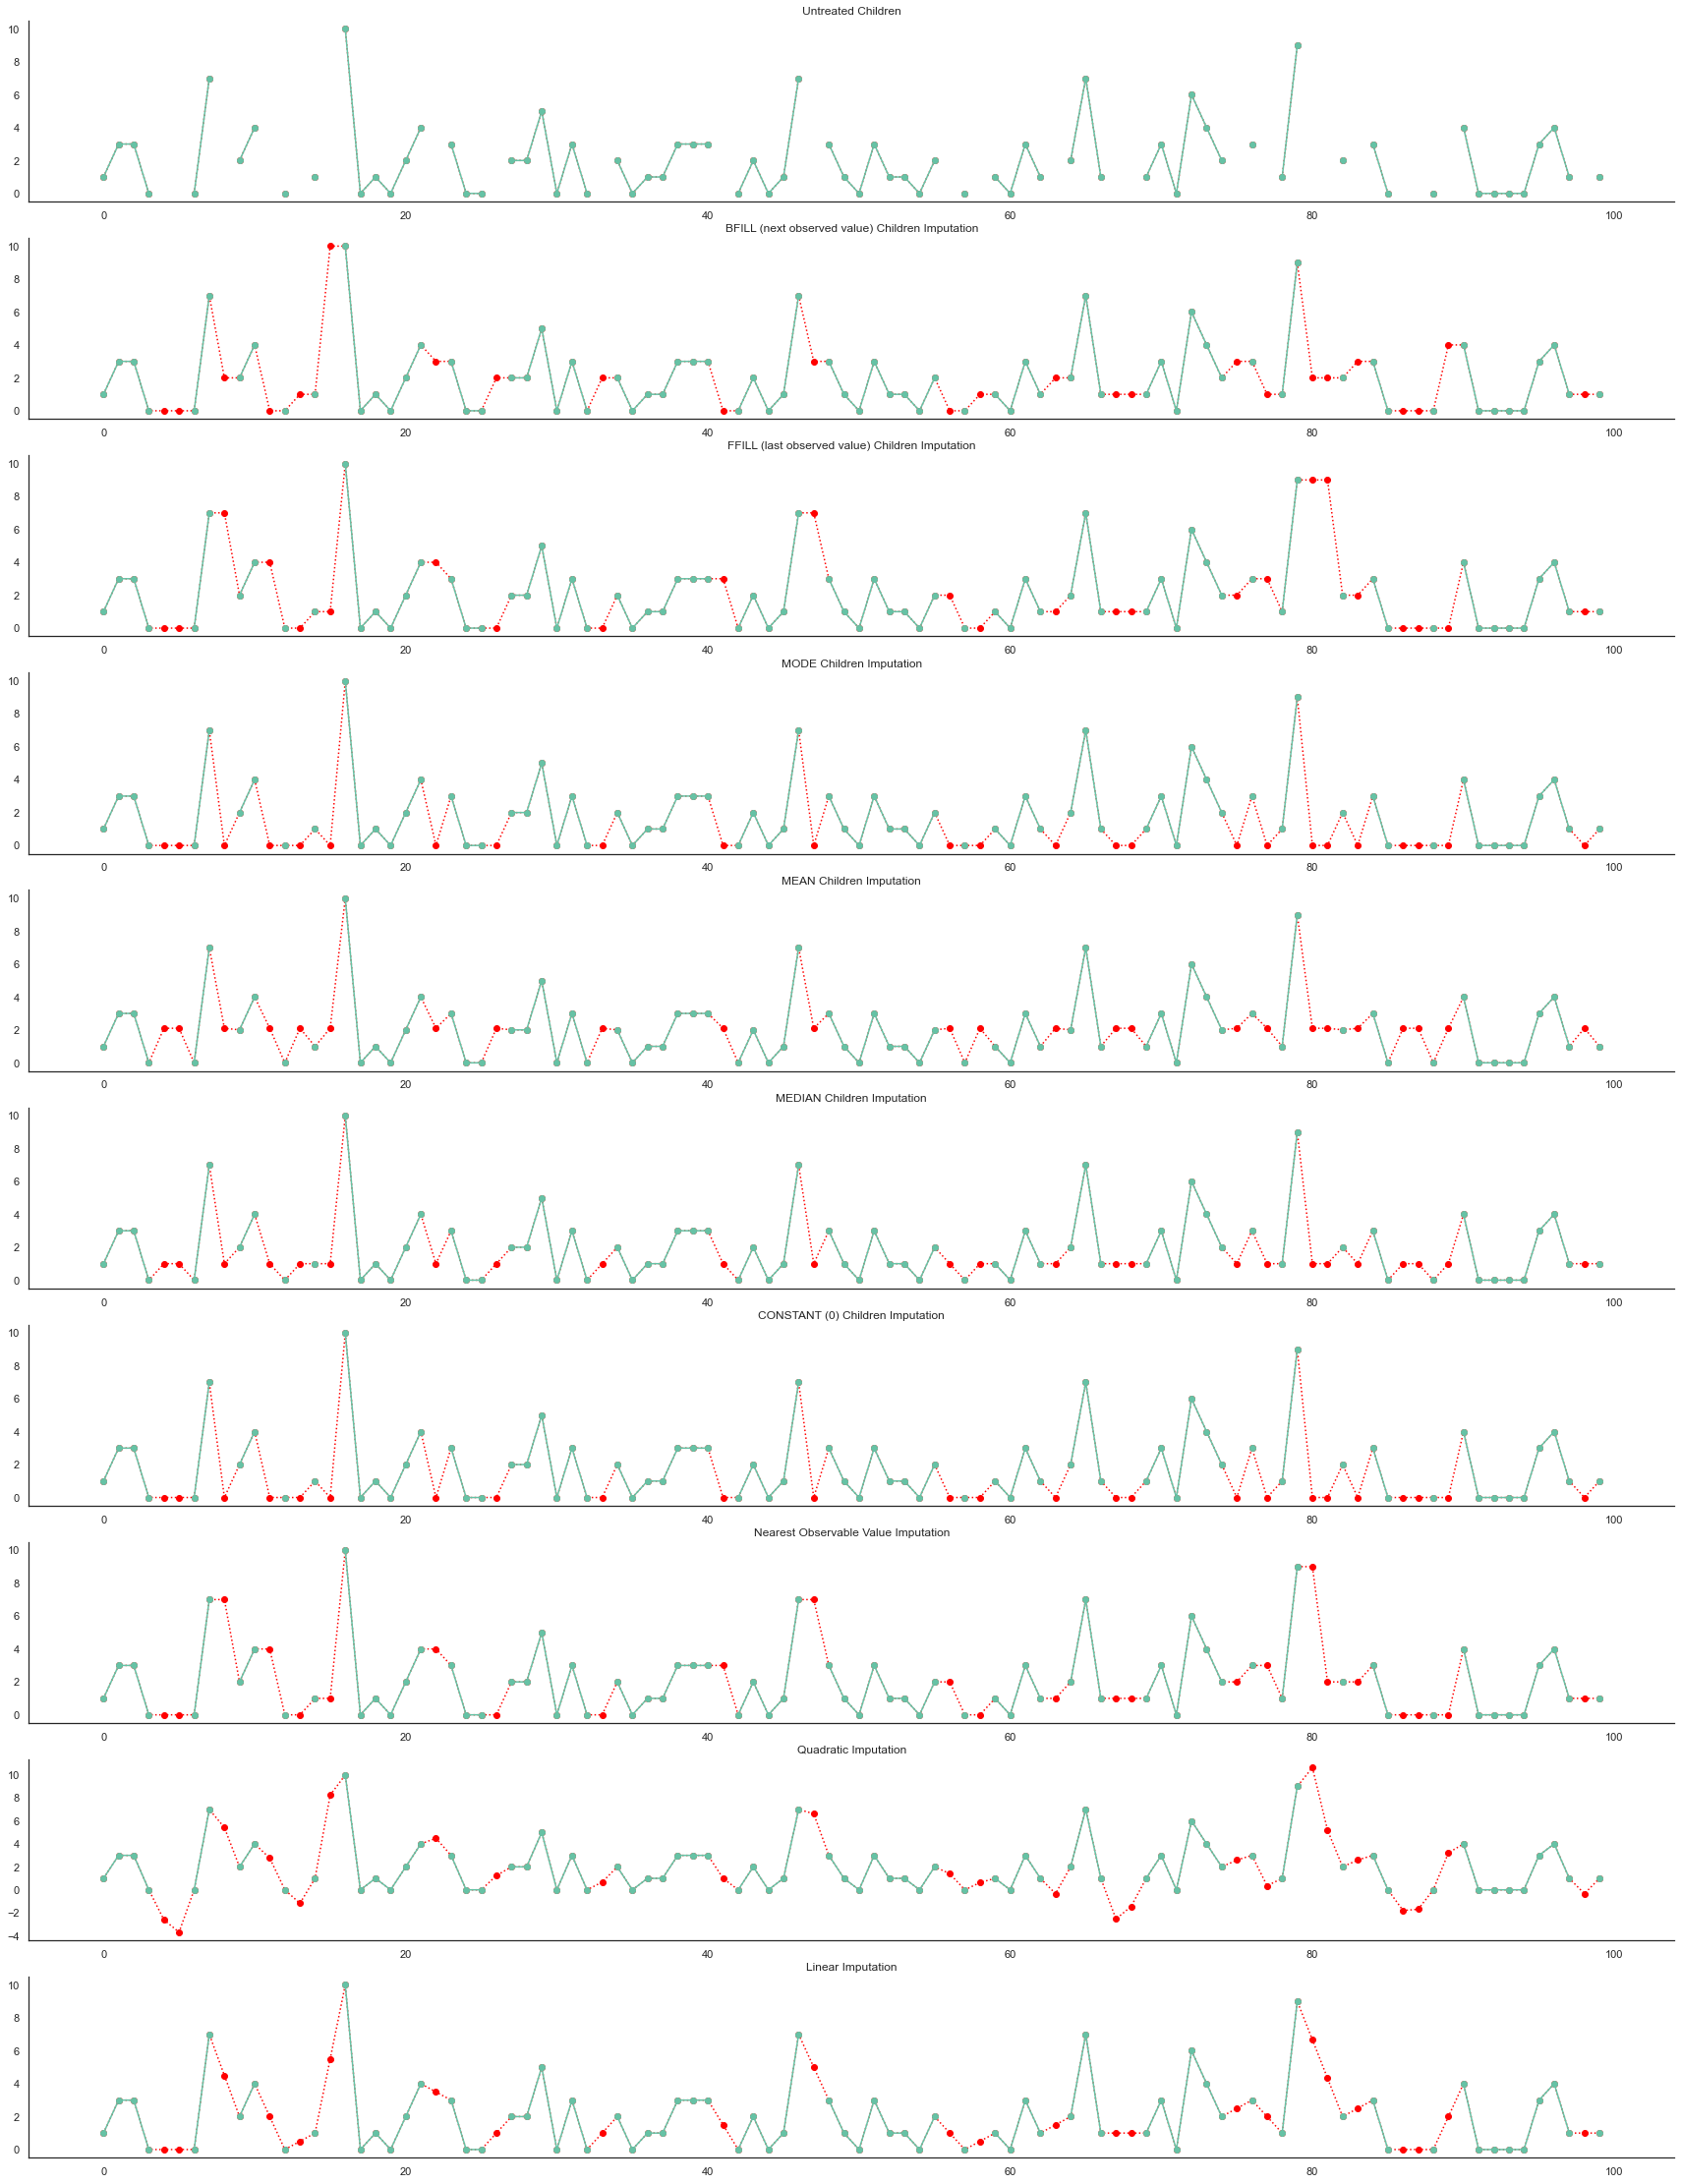

In [48]:
n = 100
col = 'Children'
imp_df = df[col].head(n)

imputations = {
    f'Untreated {col}': imp_df,
    f'BFILL (next observed value) {col} Imputation': imp_df.fillna(method='bfill'),
    f'FFILL (last observed value) {col} Imputation': imp_df.fillna(method='ffill'),    
    f'MODE {col} Imputation': imp_df.fillna(df[col].mode()[0]),
    f'MEAN {col} Imputation': imp_df.fillna(df[col].mean()),
    f'MEDIAN {col} Imputation': imp_df.fillna(df[col].median()),
    f'CONSTANT (0) {col} Imputation': imp_df.fillna(0),
    f'Nearest Observable Value Imputation': imp_df.interpolate(method='nearest'),
    f'Quadratic Imputation': imp_df.interpolate(method='quadratic'),
    f'Linear Imputation': imp_df.interpolate(method='linear'),    
}

fig, axes = plt.subplots(len(imputations), 1, figsize=(30, 40))

for ax, (k, v) in zip(axes, imputations.items()):
    _ = v.plot(title=k, color='red', marker='o', linestyle='dotted', ax=ax)
    _ = df[col].head(n).plot(marker='o', ax=ax)

#### Age Imputation Comps

In [ ]:
n = 1000
col = 'Age'
imp_df = df[col].head(n)

imputations = {  
    f'Untreated {col}': imp_df,
    f'MEAN {col} Imputation': imp_df.fillna(df[col].mean()),    
    f'MEDIAN {col} Imputation': imp_df.fillna(df[col].median()),
}

fig, axes = plt.subplots(len(imputations), 1, figsize=(30, 40))

for ax, (k, v) in zip(axes, imputations.items()):
    _ = v.plot(title=k, color='red', marker='.', linestyle='dotted', ax=ax)
    _ = df[col].head(n).plot(marker='.', ax=ax)

#### Initial_days Imputation Comps

In [ ]:
col = 'Initial_days'
rows = range(4800,5200)
imp_df = df[col].loc[rows]

imputations = {  
    f'Untreated {col}': imp_df,
    f'MODE {col} Imputation': imp_df.fillna(df[col].mode()[0]),
    f'MEAN {col} Imputation': imp_df.fillna(df[col].mean()),    
    f'MEDIAN {col} Imputation': imp_df.fillna(df[col].median()),
}

fig, axes = plt.subplots(len(imputations), 1, figsize=(30, 70))

for ax, (k, v) in zip(axes, imputations.items()):
    _ = v.plot(title=k, color='red', marker='o', linestyle='dotted', ax=ax)
    _ = df[col].loc[rows].plot(marker='o', ax=ax)

#### Imputations

In [ ]:
# uniform and multimodal distributions (mean)    
for col in ["Age", "Initial_days"]:
    treated_df[col] = df[col].fillna(df[col].mean())
    
# skewed distributions (median)    
for col in ["Income"]: 
    treated_df[col] = df[col].fillna(df[col].median())
    
# binomial distributions (mode)    
for col in ["Anxiety", "Overweight"]:
    treated_df[col] = df[col].fillna(df[col].mode()[0])

# Use Constant Value
treated_df.loc[treated_df["Soft_drink"].isnull(), ["Soft_drink"]] = 'No'
treated_df.loc[treated_df["Children"].isnull(), ["Children"]] = 0

### Verify Missing Value Imputation

In [ ]:
nan_df = treated_df.isnull().sum()

if nan_df.sum() != 0:
    raise AssertionError(f"NaN values still exist in the dataset\n{nan_df[nan_df > 0]}")
else:
    print("No remaining missing values")

### Compare Treated and Untreated Data Summaries

In [ ]:
fig, axes = plt.subplots(len(missing_cols), 1, figsize=(30, 15))
rows = range(4900,5100)

for ax, col in zip(axes, missing_cols):
    try:
        _ = data=df[col].loc[rows].plot(title=f'Untreated {col}', color='blue', ax=ax)
        _ = sns.lineplot(data=treated_df[col].loc[rows], color='red', marker='o', linestyle='dotted', ax=ax)
    except TypeError:
        # display non-numeric data in a bar chart
        _ = treated_df[col].loc[rows].value_counts().plot(title=f'Treated {col}', kind='bar', color='red', linestyle='dotted', ax=ax)
        _ = df[col].loc[rows].value_counts().plot(color='blue', kind='bar', ax=ax)
        pass
        
    # compare Treated and Untreated data descriptions
    pd.DataFrame({f'Untreated {col}': df[col].describe(), f'Treated {col}': treated_df[col].describe()})
    
fig.tight_layout(pad=0.3)    

In [ ]:
create_boxplots(treated_df)

### Outlier Treatment

In [ ]:
# numerical columns with notable outliers outliers are allowed on columns not listed here
z_score_cols = ['Children', 'VitD_levels', 'Full_meals_eaten', 'VitD_supp', 'TotalCharge', 'Additional_charges']

treated_df['Children'].value_counts()

In [ ]:
create_boxplots(treated_df)    

#### VitD_levels Outlier Exploration

In [ ]:
# pd.set_option('display.max_rows', None)
# determine what correlation exists between Gender and VitD_levels
pd.DataFrame(treated_df[treated_df['Gender'] == 'Prefer not to answer'][['VitD_levels', 'Gender', 'Age']].round().sort_values(ascending=False, by=['VitD_levels', 'Age'])).head(10)

# determine what the average VitD_levels are by Gender and Age
treated_df[['VitD_levels', 'Gender', 'Age']].round().groupby(['Gender', 'Age']).agg({'VitD_levels': 'mean'}).sort_values('VitD_levels')

# determine what correlation exists between Gender and VitD_levels
vitd_df = df.copy()
vitd_df['Gender'] = df['Gender'].map({'Prefer not to answer': 0, 'Male': 1, 'Female': 2})
vitd_df.corr()['VitD_levels'].sort_values(ascending=False)

#### VitD_levels Outlier Treatment

In [ ]:
# no treatment - retaining existing values

#### Children Outlier Exploration

In [ ]:
create_hist_and_boxplots(df, "Children")

#### Children Outlier Treatment

In [ ]:
col = "Children"

children_z_df = abs(stats.zscore(df[col], nan_policy="omit"))
pd.DataFrame(df[children_z_df > 3][col].value_counts())

treated_df[col] = treated_df[col].astype("int")

# store maximum number of children that is a nonoutlier
max_num_children = df[children_z_df < 3][col].max()

# set the Children outliers to the max nonoutlier
treated_df.loc[treated_df[col] > max_num_children, col] = max_num_children

assert treated_df[col].max() == max_num_children

create_hist_and_boxplots(df, col)
create_hist_and_boxplots(treated_df, col)

#### Full_meals_eaten Outlier Exploration

In [ ]:
create_hist_and_boxplots(df, "Full_meals_eaten")

#### Full_meals_eaten Outlier Treatment

In [ ]:
col = "Full_meals_eaten"

meals_z_df = abs(stats.zscore(df[col], nan_policy="omit"))
pd.DataFrame(df[meals_z_df > 3][col].value_counts())

treated_df[col] = treated_df[col].astype("int")

# store maximum number of children that is a nonoutlier
max_num_meals = df[children_z_df < 3][col].max()
med_num_meals = df[col].median()

# set the meals eaten outliers to the median value
treated_df.loc[meals_z_df > 3, col] = med_num_meals

assert treated_df[col].max() <= max_num_meals

In [ ]:
create_hist_and_boxplots(df, "Full_meals_eaten")
create_hist_and_boxplots(treated_df, "Full_meals_eaten")

### Re-Expression Categories Treatment

In [ ]:
# convert categorical string values to category data type

# convert "Soft_drink" nan's to 'No'
treated_df.loc[df["Soft_drink"].isna(), "Soft_drink"] = "No"

# convert "Overweight" float64's to Yes/No bools
treated_df["Overweight"] = treated_df["Overweight"].map({np.nan: 'No', 0: 'No', 'No': 'No', 1: 'Yes', 'Yes': 'Yes'})

treated_df["Anxiety"] = treated_df["Anxiety"].map({np.nan: 'No', 0: 'No', 'No': 'No', 1: 'Yes', 'Yes': 'Yes'})

# validate a value exists for each row
assert len(treated_df["Soft_drink"].isna().index) == len(treated_df.index)

# categorical columns and potential categorical columns
ctg_cols = ["Anxiety", "Area", "Timezone", "Employment", "Education",  "Marital", "Gender", "ReAdmis", "Soft_drink", "Initial_admin", "HighBlood", "Stroke", "Complication_risk", "Overweight", "Arthritis", "Diabetes", "Hyperlipidemia", "BackPain", "Allergic_rhinitis", "Reflux_esophagitis", "Asthma", "Services"]

for col in ctg_cols:
    # print(treated_df[col].unique())
    print(f"--- COLUMN: '{col}' ---")    
    # sort the unique values and print 1 value per line
    # print(*np.sort(df[col].unique()), sep='\n', end="\n\n")

    # convert column to a category
    treated_df[col] = treated_df[col].astype("category")

    # confirm the values successfully converted     
    assert treated_df[col].dtype == "category"
    
    # report categorical counts   
    treated_df[col].value_counts()
    
ctg_cols = treated_df.select_dtypes('category').columns

In [ ]:
plot_categorical_counts(treated_df, ctg_cols)

In [ ]:
if treated_df.columns[treated_df.dtypes == 'category'].any():
    category_df = treated_df.copy()
    encodings, encoded_df, ctg_cols = create_category_encodings(category_df)
    treated_df = encoded_df
else:
    print("categories are already encoded")

# ctg_cols
plot_categorical_counts(treated_df, ['Area', 'Timezone', 'Education', 'Employment', 'Marital', 'Gender',
    'ReAdmis', 'Soft_drink', 'Initial_admin', 'HighBlood', 'Stroke',
       'Complication_risk', 'Overweight', 'Arthritis', 'Diabetes',
       'Hyperlipidemia', 'BackPain', 'Anxiety', 'Allergic_rhinitis',
       'Reflux_esophagitis', 'Asthma', 'Services'])

### Other Data Cleaning Treatment

#### Drop 'Unnamed: 0' column

In [ ]:
# trimwhite space from string columns
str_cols = treated_df.select_dtypes('object')
treated_df[str_cols.columns] = str_cols.apply(lambda s: s.str.strip())

In [ ]:
# Verify these columns are the same, if so drop the "Unnamed: 0" column
if "Unnamed: 0" in treated_df.columns and treated_df["Unnamed: 0"].equals(treated_df["CaseOrder"]):
    print("Dropping 'Unnamed: 0' column")
    treated_df = treated_df.drop(columns="Unnamed: 0", axis=1)    

#### Round Age and Children Values

In [ ]:
treated_df['Age'] = treated_df['Age'].astype('int')
assert treated_df['Age'].dtype == 'int'

In [ ]:
treated_df['Children'] = treated_df['Children'].astype('int')
assert treated_df['Children'].dtype == 'int'

## D2: Justification of Mitigation Methods

## D3: Summary of the Outcomes

In [ ]:
_ = treated_df.hist(figsize = (25,25))

## D4: Mitigation Code 

In [ ]:
treated_df.to_csv('clean_data.csv', index=False)
write_encodings_csv(encodings)

In [ ]:
# example decode an encoded value by feature name and encoded value
encodings['Complication_risk'].inverse_transform([2])

## D5: Clean Data

## D6: Limitations

## D7: Impact of the Limitations

## E1. Principal Components

In [ ]:
pca_df = treated_df.copy()
treated_pca_df = treated_df.copy()
pca_df.describe(exclude='number')
pca_df.shape

### Correlation Heatmap

In [ ]:
cmap = sns.diverging_palette(h_neg=10, h_pos=240, as_cmap=True)
fig, ax = plt.subplots(figsize=(25,10))
corr_df = pca_df.corr()

# mask part of the matrix
mask = np.zeros_like(corr_df)
mask[np.triu_indices_from(mask)] = True

_ = sns.heatmap(corr_df, center=0, cmap=cmap, annot=True, fmt=".1f", vmin=-1.0, vmax = 1.0, mask=mask, linewidths=.5, ax=ax)

In [ ]:
# store the string columns in a separate dataframe
str_cols = treated_df.select_dtypes('object')
str_cols.columns

# drop the string columns
treated_pca_df = treated_pca_df.drop(str_cols.columns, axis=1, errors='ignore')
treated_pca_df.shape

In [ ]:
treated_pca_df.var().sort_values(ascending=False).head(15)

In [ ]:
patient_features = [
    "Additional_charges",    
    "Full_meals_eaten",
    "Complication_risk",    
    "Children",
    "Education",
    "Doc_visits",
    "Zip",
    "Lng",
    "Lat",
    "Population",
    "Timezone",
    "Services",
    "ReAdmis",
    "Initial_admin",
    "Initial_days",
    "TotalCharge",
    "Age",
    "VitD_levels",
    "HighBlood",
    "Item1",
    "Item2",
    "Item3",
    "Item4",
    "Item5",
    "Item6",
    "Item7",
    "Item8",
]

# treated_pca_df[patient_features].var()

In [ ]:
# create a dataframe using a subset of numerical features
treated_pca_feats_df = treated_pca_df[patient_features].copy()

In [ ]:
from sklearn.feature_selection import VarianceThreshold
vt_df = treated_pca_feats_df.copy()

# Feature selector that removes all low-variance features based on a variance threshold.
sel = VarianceThreshold(threshold=.75)

sel.fit_transform(vt_df)
# sel.fit_transform(vt_df / vt_df.mean())
# boolean array of shape [# input features], where an element is True if its corresponding feature is selected for retention.
mask = sel.get_support()

# retained columns
retain_cols = vt_df.loc[:, mask].columns

# dropped columns
drop_cols = vt_df.loc[:, ~mask].columns

pd.DataFrame({'retained': retain_cols})
pd.DataFrame({'dropped fields': drop_cols})

#### An optimal number of components

In [ ]:
pipe = Pipeline([("scaler", StandardScaler()), ("reducer", PCA())])

pipe.fit(treated_pca_feats_df)
pca = pipe.steps[1][1]
num_components = len(pca.components_)
var = pipe.steps[1][1].explained_variance_ratio_

fig, axs = plt.subplots(1, 1, figsize=(15, 5))
axs.set_title('scree plot graph')
sns.lineplot(data=var, ax=axs)

plt.xlabel('Principal component')
plt.ylabel('Explained variance ratio')
plt.xticks(np.arange(0, num_components, 1))

plt.show()

In [ ]:
print(pca.explained_variance_ratio_.cumsum())

#### Loadings Table

In [ ]:
# create dataframe from principal components
# correlation coefficients between the features and the principal components
loadings = pd.DataFrame(pca.components_.T, columns=[f"PC{i}" for i in range(1, num_components +1)], index=treated_pca_feats_df.columns)
loadings

## E2. Criteria Used

In [ ]:
test_pca_normalized = StandardScaler().fit_transform(treated_pca_feats_df)

cov_matrix = np.dot(test_pca_normalized.T, test_pca_normalized / treated_pca_feats_df.shape[0])

eigenvalues = [
    np.dot(eigenvector.T, np.dot(cov_matrix, eigenvector))
    for eigenvector in pca.components_
]

plt.figure(figsize=(15, 5))

plt.plot(eigenvalues, linewidth=2)
plt.xticks(np.arange(0, treated_pca_feats_df.shape[1], 1))
plt.axhline(y=1, color="gray", linestyle="--")
plt.xlabel('Principal component index')
plt.ylabel('Explained variance ratio')

treated_pca_feats_df.shape[1]
cs = pca.explained_variance_ratio_.cumsum()
evs = np.array(eigenvalues)
num_pcs_to_use = len(evs[evs >= 1])

# The Kaiser rule: drop all components with eigenvalues < 1.0 
print(f"Based on the Kaiser Rule, we'll keep the first {num_pcs_to_use} PCs")

## E3. Benefits

# Part IV. Supporting Documents
---

## F. Video

## G. Web Sources

- https://stackoverflow.com/q/47139203
- https://stackoverflow.com/a/57649212
- https://datascience.stackexchange.com/questions/60955/how-to-check-all-values-in-particular-column-has-same-data-type-or-not
- https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.reset_index.html
- https://stackoverflow.com/questions/40339886/pandas-concat-generates-nan-values
- https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.select_dtypes.htmlhttps://pandas.pydata.org/docs/reference/api/pandas.DataFrame.select_dtypes.html
- https://stackoverflow.com/questions/43392588/how-to-increase-the-figure-size-of-dataframe-hist-for-pandas-0-11-0
- https://numpy.org/doc/stable/reference/generated/numpy.all.html
- https://stackoverflow.com/a/53585379
- https://stackoverflow.com/questions/31029560/plotting-categorical-data-with-pandas-and-matplotlib
- https://stackoverflow.com/questions/43392588/how-to-increase-the-figure-size-of-dataframe-hist-for-pandas-0-11-0
- https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.select_dtypes.html
- https://datatofish.com/check-nan-pandas-dataframe/
- https://stackoverflow.com/questions/22391433/count-the-frequency-that-a-value-occurs-in-a-dataframe-column
- https://stackoverflow.com/questions/38913965/make-the-size-of-a-heatmap-bigger-with-seaborn
- https://seaborn.pydata.org/generated/seaborn.heatmap.html
- https://matplotlib.org/stable/gallery/subplots_axes_and_figures/figure_title.html
- https://www.geeksforgeeks.org/python-visualize-missing-values-nan-values-using-missingno-library/https://www.geeksforgeeks.org/python-visualize-missing-values-nan-values-using-missingno-library/
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-
-

## H. Sources/References